In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# 3. Data Scaling

* Due to the different types of information that Categorical features and Numerical features provide, each requires unique data scaling methods. Therefore, before normalizing features, we must split them into numeric and categorical sets.
* Regarding the numerical variables, the objective is to place them into the same scale, from 0 to 1, where 1 refers to the maximum value of the feature while 0 refers to the minimum value of the feature. One reason for normalizing / scaling the data is to prevent the model from giving more importance to variables with larger absolute numbers, since we do not want to make any assumptions on the level of importance of each feature. It is relevant to mention that while scaling we only consider information obtained from the training data. Only after we can use the minimum and maximum values of the training dataset for each variable to scale the validation dataset.
* Concerning categorical features, these are encoded to be readable by the models, as these do not typically process non-numeric data directly. To do so, we used the Ordinal Encoder method to transform the categorical variables by assigning each category an unique integer based on its order or occurrence


In [2]:
# Load the data (train and test)
X_train_DS = pd.read_csv('datasets/feature_engineering_train_delivery1.csv', index_col=0)
X_val_DS = pd.read_csv('datasets/feature_engineering_val_delivery1.csv', index_col=0)
y_train_DS = pd.read_csv('datasets/feature_engineering_y_train_delivery1.csv', index_col=0)
y_val_DS = pd.read_csv('datasets/feature_engineering_y_val_delivery1.csv', index_col=0)

X_test_DS = pd.read_csv('datasets/feature_engineering_test_delivery1.csv', index_col=0)

In [3]:
X_train_DS.shape, y_train_DS.shape, X_val_DS.shape,  y_val_DS.shape

((441804, 50), (441804, 1), (110586, 50), (110586, 1))

In [4]:
X_test_DS.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,...,Season of Accident,Region Risk Percentage,Region Risk Level,Industry Claim Percentage,Industry Risk Level,Both C2 and C3,Only C2,Only C3,No C2 or C3,Geo-Industry Risk
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,19.0,0.0,0,892.62,2003.0,0,INDEMNITY INSURANCE CO OF,1A. PRIVATE,BRONX,0,...,Winter,0.069952,Medium Risk,0.064538,Medium Risk,0,0,0,0,0.006847
6166141,19.0,0.0,0,892.62,2003.0,0,A I U INSURANCE COMPANY,1A. PRIVATE,QUEENS,0,...,Autumn,0.101588,High Risk,0.031869,Medium Risk,0,0,0,0,0.001974
6165907,59.0,0.0,0,0.00,1963.0,0,AMGUARD INSURANCE COMPANY,1A. PRIVATE,WESTCHESTER,0,...,Winter,0.044465,Medium Risk,0.036985,Medium Risk,0,0,0,0,0.001618
6166047,2022.0,0.0,0,0.00,0.0,0,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,QUEENS,0,...,Winter,0.101588,High Risk,0.064538,Medium Risk,0,0,0,0,0.014597
6166102,25.0,0.0,0,0.00,1997.0,0,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,KINGS,0,...,Winter,0.093012,High Risk,0.000593,Low Risk,0,0,0,0,0.000034


In [5]:
X_train_DS.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Assembly Year', 'Accident Year', 'C-2 Date Year', 'Assembly Month',
       'Accident Month', 'C-2 Date Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Accident',
  

In [6]:
X_val_DS.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Assembly Year', 'Accident Year', 'C-2 Date Year', 'Assembly Month',
       'Accident Month', 'C-2 Date Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Accident',
  

In [7]:
# Convert the 'Accident on Weekday' feature from boolean (True/False) to binary (1/0) in the X_train_DS dataset
X_train_DS['Accident on Weekday'] = X_train_DS['Accident on Weekday'].map({True: 1, False: 0})

# Convert the 'Accident on Weekday' feature from boolean (True/False) to binary (1/0) in the X_val_DS dataset
X_val_DS['Accident on Weekday'] = X_val_DS['Accident on Weekday'].map({True: 1, False: 0})

In [8]:
print(X_train_DS['Medical Fee Region'].dropna().unique())  # Excludes NaN explicitly


['IV' 'I' 'II' 'III']


In [9]:
# Define a mapping dictionary for the 'Medical Fee Region' values
mapping = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'UK': 0}  # Assign a value to 'UK' based on its meaning

# Apply the mapping to the 'Medical Fee Region' column in the X_train_DS dataset
X_train_DS['Medical Fee Region'] = X_train_DS['Medical Fee Region'].map(mapping)

# Apply the mapping to the 'Medical Fee Region' column in the X_val_DS dataset
X_val_DS['Medical Fee Region'] = X_val_DS['Medical Fee Region'].map(mapping)

In [10]:
X_train_DS.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Assembly Year', 'Accident Year', 'C-2 Date Year', 'Assembly Month',
       'Accident Month', 'C-2 Date Month', 'Age Group',
       'Frequent Injury Cause', 'Broad Body Part',
       'Dependency-to-Income Ratio', 'Injury-Location Pair',
       'Time Between Events', 'Accident on Weekday', 'Injury Complexity',
       'Carrier Accident Density', 'Season of Accident',
  

In [11]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year','C-2 Date Year',
                    'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events',
                    'Carrier Accident Density', 'Industry Claim Percentage', 'Region Risk Percentage', 'Geo-Industry Risk' ]
                    
categorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name',
                        'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Age Group', 'Broad Body Part', 'Injury-Location Pair',
                        'Injury Complexity', 'Season of Accident', 'Region Risk Level', 'Industry Risk Level']
                        
binary_features = ['IME-4 Count','Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 
                   'First Hearing Date', 'Gender','Frequent Injury Cause', 'Accident on Weekday', 'Both C2 and C3', 'C-3 Date',
                   'Only C2', 'Only C3', 'No C2 or C3']

cyclic_features = ['Accident Month', 'Assembly Month', 'C-2 Date Month']


In [12]:
# Split the features into subsets based on their type
# Numeric features: Continuous or discrete numerical data
X_train_numeric = X_train_DS[numeric_features]
X_train_categorical = X_train_DS[categorical_features]
X_train_binary = X_train_DS[binary_features]
X_train_cyclic = X_train_DS[cyclic_features]

X_val_numeric = X_val_DS[numeric_features]
X_val_categorical = X_val_DS[categorical_features]
X_val_binary = X_val_DS[binary_features]
X_val_cyclic = X_val_DS[cyclic_features]

X_test_numeric = X_test_DS[numeric_features]
X_test_categorical = X_test_DS[categorical_features]
X_test_binary = X_test_DS[binary_features]
X_test_cyclic = X_test_DS[cyclic_features]

## 3.1 Data Scaling for Numerical

In [13]:
# Initialize scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply RobustScaler
X_train_numeric_robust_scaled = pd.DataFrame(
    robust_scaler.fit_transform(X_train_numeric),
    columns=numeric_features,
    index=X_train_numeric.index
)
X_val_numeric_robust_scaled = pd.DataFrame(
    robust_scaler.transform(X_val_numeric),
    columns=numeric_features,
    index=X_val_numeric.index
)
X_test_numeric_robust_scaled = pd.DataFrame(
    robust_scaler.transform(X_test_numeric),
    columns=numeric_features,
    index=X_test_numeric.index
)

# Apply MinMaxScaler
X_train_numeric_minmax_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(X_train_numeric),
    columns=numeric_features,
    index=X_train_numeric.index
)
X_val_numeric_minmax_scaled = pd.DataFrame(
    minmax_scaler.transform(X_val_numeric),
    columns=numeric_features,
    index=X_val_numeric.index
)
X_test_numeric_minmax_scaled = pd.DataFrame(
    minmax_scaler.transform(X_test_numeric),
    columns=numeric_features,
    index=X_test_numeric.index
)

# Apply StandardScaler
X_train_numeric_standard_scaled = pd.DataFrame(
    standard_scaler.fit_transform(X_train_numeric),
    columns=numeric_features,
    index=X_train_numeric.index
)
X_val_numeric_standard_scaled = pd.DataFrame(
    standard_scaler.transform(X_val_numeric),
    columns=numeric_features,
    index=X_val_numeric.index
)
X_test_numeric_standard_scaled = pd.DataFrame(
    standard_scaler.transform(X_test_numeric),
    columns=numeric_features,
    index=X_test_numeric.index
)


In [14]:
# Create a DataFrame to compare scaler outputs
comparison_table = pd.DataFrame({
    "Original": X_train_numeric.head(2).stack().values,
    "RobustScaled": X_train_numeric_robust_scaled.head(2).stack().values,
    "MinMaxScaled": X_train_numeric_minmax_scaled.head(2).stack().values,
    "StandardScaled": X_train_numeric_standard_scaled.head(2).stack().values
})

# Display the comparison table
print(comparison_table)


       Original  RobustScaled  MinMaxScaled  StandardScaled
0     50.000000      0.322120      0.523077        0.534376
1   1500.000000      0.620181      0.516650        0.745266
2   1971.000000     -0.322120      0.492754       -0.527419
3      1.000000     -0.500000      0.166667       -1.002624
4   2021.000000      0.000000      0.916667        0.065785
5   2021.000000      0.000000      0.785714       -0.073879
6   2021.000000      0.000000      0.500000       -0.064818
7      0.000667     -0.601564      0.003431       -0.775051
8      0.000000      0.000000      0.000000       -0.206404
9      0.195872      6.521370      1.000000        2.006792
10     0.036985     -0.322291      0.178403       -0.857125
11     0.024033     -0.379231      0.230430       -0.844751
12     0.000783     -0.310122      0.034597       -0.814316
13    45.000000      0.094848      0.446154        0.159323
14  1265.750000      0.232830      0.435209        0.233392
15  1976.000000     -0.094848      0.565

It is explained in the report that we chose MinMax scaling for final use.

## 3.2 Data Scaling for Categorical

In [15]:
X_train_categorical.columns

Index(['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Age Group', 'Broad Body Part', 'Injury-Location Pair',
       'Injury Complexity', 'Season of Accident', 'Region Risk Level',
       'Industry Risk Level'],
      dtype='object')

In [16]:
X_train_categorical.head()

,Carrier Name,Carrier Type,County of Injury,District Name,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,...,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Age Group,Broad Body Part,Injury-Location Pair,Injury Complexity,Season of Accident,Region Risk Level,Industry Risk Level
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5840724,STATE INSURANCE FUND,2A. SIF,RICHMOND,NYC,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,4,25.0,FROM DIFFERENT LEVEL (ELEVATION),1.0,...,42.0,LOWER BACK AREA,10304.0,Adult,Trunk,42.0 - NO PHYSICAL INJURY,2.0,Autumn,Medium Risk,Medium Risk
5828518,STATE INSURANCE FUND,2A. SIF,NASSAU,NYC,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,4,2.0,HOT OBJECTS OR SUBSTANCES,4.0,...,35.0,HAND,11520.0,Adult,Upper Extremities,35.0 - BURN,16.0,Autumn,Medium Risk,High Risk
5623558,TRAVELERS INDEMNITY CO OF CONN,1A. PRIVATE,QUEENS,NYC,52.0,FINANCE AND INSURANCE,4,97.0,REPETITIVE MOTION,78.0,...,34.0,WRIST,11358.0,Adult,Upper Extremities,34.0 - CARPAL TUNNEL SYNDROME,390.0,Autumn,High Risk,Low Risk
5630561,AMERICAN ZURICH INSURANCE CO,1A. PRIVATE,KINGS,NYC,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,4,83.0,PANDEMIC,83.0,...,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11236.0,Adult,Multiple Body Parts,90.0 - COVID-19,249.0,Winter,High Risk,High Risk
5708079,AMERICAN CASUALTY CO OF,1A. PRIVATE,TOMPKINS,BINGHAMTON,23.0,CONSTRUCTION,1,98.0,"CUMULATIVE, NOC",52.0,...,35.0,HAND,14850.0,Old,Upper Extremities,35.0 - STRAIN OR TEAR,208.0,Spring,Low Risk,Medium Risk


In [17]:
#We're having a cardinality issue, with a lot of features. One Hot Encoder is generating a lot of columns due to it.
# We will assess that problem here and then maybe drop some redundant features.

# Check cardinality of categorical features
cardinality = X_train_categorical.nunique()
cardinality

Carrier Name                         1428
Carrier Type                            8
County of Injury                       63
District Name                           8
Industry Code                          24
Industry Code Description              20
Medical Fee Region                      4
WCIO Cause of Injury Code              77
WCIO Cause of Injury Description       74
WCIO Nature of Injury Code             51
WCIO Nature of Injury Description      51
WCIO Part Of Body Code                 56
WCIO Part Of Body Description          54
Zip Code                             7122
Age Group                               4
Broad Body Part                         9
Injury-Location Pair                 1742
Injury Complexity                     262
Season of Accident                      4
Region Risk Level                       3
Industry Risk Level                     3
dtype: int64

Additionally, we have identified features that contain both a code and its corresponding description. In order to streamline the model and improve efficiency, we have decided to drop the description columns while retaining the code. Although this decision may reduce model interpretability to some extent, it will help simplify the data without sacrificing critical information.

The features that will be dropped are:

- Industry Code Description
- WCIO Cause of Injury Description
- WCIO Nature of Injury Description
- WCIO Part Of Body Description

In [18]:
# Remove the values Descriptions from the list of categorical features
X_train_categorical = X_train_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)
X_val_categorical = X_val_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)

# Check cardinality of categorical features
X_train_categorical.nunique()

Carrier Name                  1428
Carrier Type                     8
County of Injury                63
District Name                    8
Industry Code                   24
Medical Fee Region               4
WCIO Cause of Injury Code       77
WCIO Nature of Injury Code      51
WCIO Part Of Body Code          56
Zip Code                      7122
Age Group                        4
Broad Body Part                  9
Injury-Location Pair          1742
Injury Complexity              262
Season of Accident               4
Region Risk Level                3
Industry Risk Level              3
dtype: int64

In [19]:
#Check the value counts of 'Industry Risk Level' and 'Region Risk Level' to see if we can drop them
X_train_categorical['Industry Risk Level'].value_counts()

Industry Risk Level
Medium Risk    175848
High Risk      161338
Low Risk       104618
Name: count, dtype: int64

In [20]:
# Set the threshold for low cardinality
low_cardinality_threshold = 10

# Separate columns based on cardinality
low_cardinality_cols = [col for col in X_train_categorical.columns if X_train_categorical[col].nunique() <= low_cardinality_threshold]
high_cardinality_cols = [col for col in X_train_categorical.columns if X_train_categorical[col].nunique() > low_cardinality_threshold]

# Apply One-Hot Encoding to Low Cardinality Columns
# OneHotEncoder will transform categorical values into binary columns (0 or 1)
ohc = OneHotEncoder(sparse_output= False, drop="first", handle_unknown="ignore")

# Apply the OneHotEncoder to the training set for low cardinality features
ohc_train_feat = ohc.fit_transform(X_train_categorical[low_cardinality_cols])

# Transform the validation and test sets using the same encoder (no fitting)
ohc_val_feat = ohc.transform(X_val_categorical[low_cardinality_cols])
ohc_test_feat = ohc.transform(X_test_categorical[low_cardinality_cols])


In [21]:
print(X_train_categorical[low_cardinality_cols].head())

                 Carrier Type District Name  Medical Fee Region Age Group  \
Claim Identifier                                                            
5840724               2A. SIF           NYC                   4     Adult   
5828518               2A. SIF           NYC                   4     Adult   
5623558           1A. PRIVATE           NYC                   4     Adult   
5630561           1A. PRIVATE           NYC                   4     Adult   
5708079           1A. PRIVATE    BINGHAMTON                   1       Old   

                      Broad Body Part Season of Accident Region Risk Level  \
Claim Identifier                                                             
5840724                         Trunk             Autumn       Medium Risk   
5828518             Upper Extremities             Autumn       Medium Risk   
5623558             Upper Extremities             Autumn         High Risk   
5630561           Multiple Body Parts             Winter         High 

In [22]:
print(X_train_categorical[high_cardinality_cols].dtypes)

Carrier Name                   object
County of Injury               object
Industry Code                 float64
WCIO Cause of Injury Code     float64
WCIO Nature of Injury Code    float64
WCIO Part Of Body Code        float64
Zip Code                      float64
Injury-Location Pair           object
Injury Complexity             float64
dtype: object


In [23]:
low_cardinality_cols

['Carrier Type',
 'District Name',
 'Medical Fee Region',
 'Age Group',
 'Broad Body Part',
 'Season of Accident',
 'Region Risk Level',
 'Industry Risk Level']

In [24]:
ohc_train_feat

array([[1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
# Create DataFrames for one-hot encoded features
ohc_train_df = pd.DataFrame(ohc_train_feat, index=X_train_categorical.index, columns=ohc.get_feature_names_out(low_cardinality_cols))
ohc_val_df = pd.DataFrame(ohc_val_feat, index=X_val_categorical.index, columns=ohc.get_feature_names_out(low_cardinality_cols))
ohc_test_df = pd.DataFrame(ohc_test_feat, index=X_test_categorical.index, columns=ohc.get_feature_names_out(low_cardinality_cols))

In [26]:
ohc_train_df.columns

Index(['Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC',
       'Carrier Type_4A. SELF PRIVATE',
       'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)',
       'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS',
       'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN',
       'District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE', 'Medical Fee Region_2',
       'Medical Fee Region_3', 'Medical Fee Region_4', 'Age Group_Old',
       'Age Group_Other', 'Age Group_Young', 'Broad Body Part_Internal Organs',
       'Broad Body Part_Lower Extremities',
       'Broad Body Part_Multiple Body Parts', 'Broad Body Part_Trunk',
       'Broad Body Part_Unclassified', 'Broad Body Part_Unknown',
       'Broad Body Part_Upper Extremities', 'Broad Body Part_Whole Body',
       'Season of Accident_Spring', 'Season of Acc

In [27]:
#check the shape of the dataframes of ohc
print("OHC Train shape: ", ohc_train_df.shape)
print("OHC Val shape: ", ohc_val_df.shape)
print("OHC Test shape: ", ohc_test_df.shape)

OHC Train shape:  (441804, 35)
OHC Val shape:  (110586, 35)
OHC Test shape:  (387975, 35)


In [28]:
print(X_train_categorical[high_cardinality_cols].dtypes)

Carrier Name                   object
County of Injury               object
Industry Code                 float64
WCIO Cause of Injury Code     float64
WCIO Nature of Injury Code    float64
WCIO Part Of Body Code        float64
Zip Code                      float64
Injury-Location Pair           object
Injury Complexity             float64
dtype: object


In [29]:
# Split the high cardinality columns into object and numeric columns
# Identify columns with object data type within the high cardinality columns
high_cardinality_object_cols = X_train_categorical[high_cardinality_cols].select_dtypes(include=['object']).columns

# Identify columns with numeric data type within the high cardinality columns
high_cardinality_numeric_cols = X_train_categorical[high_cardinality_cols].select_dtypes(include=['int64', 'float64']).columns

In [30]:
# Can you check for missing values in the high cardinality object columns?
print(X_train_categorical[high_cardinality_object_cols].isna().sum())

Carrier Name            0
County of Injury        0
Injury-Location Pair    0
dtype: int64


In [31]:
# Check the value counts for the high cardinality object columns
print(X_train_categorical[['Carrier Name']].value_counts())

Carrier Name                
STATE INSURANCE FUND            86537
POLICE, FIRE, SANITATION        16568
AMERICAN ZURICH INSURANCE CO    13593
CHARTER OAK FIRE INS CO         13375
INDEMNITY INS. OF N AMERICA     11296
                                ...  
AMERICAN PROTECTION INS CO.         1
GREENPORT UNION FREE                1
GENESEE VALLEY CENTRAL              1
BOCES DISTRICT OF ORANGE &          1
BITCO GENERAL INSURANCE             1
Name: count, Length: 1428, dtype: int64


In [32]:
# Check if y_train_DS is not a pandas Series
if not isinstance(y_train_DS, pd.Series):
    # Convert y_train_DS to a pandas Series and assign the name 'Target'
    # The squeeze() function is used to convert the data to a 1D array if it is currently 2D
    y_train_DS = pd.Series(y_train_DS.squeeze(), name='Target')

In [33]:
#Check y train value counts
y_train_DS.value_counts()

Target
2. NON-COMP        226777
4. TEMPORARY       113466
3. MED ONLY         53318
5. PPD SCH LOSS     36356
1. CANCELLED         8224
6. PPD NSL           3240
8. DEATH              353
7. PTD                 70
Name: count, dtype: int64

In [34]:
X_train_categorical[high_cardinality_object_cols]

,Carrier Name,County of Injury,Injury-Location Pair
Claim Identifier,,,
5840724,STATE INSURANCE FUND,RICHMOND,42.0 - NO PHYSICAL INJURY
5828518,STATE INSURANCE FUND,NASSAU,35.0 - BURN
5623558,TRAVELERS INDEMNITY CO OF CONN,QUEENS,34.0 - CARPAL TUNNEL SYNDROME
5630561,AMERICAN ZURICH INSURANCE CO,KINGS,90.0 - COVID-19
5708079,AMERICAN CASUALTY CO OF,TOMPKINS,35.0 - STRAIN OR TEAR
...,...,...,...
6117605,STATE INSURANCE FUND,ORANGE,42.0 - FOREIGN BODY
5524219,"CNY OTHER THAN ED, HED WATER",RICHMOND,48.0 - HERNIA
5553447,SECURITY NATIONAL INSURANCE CO,MONROE,42.0 - STRAIN OR TEAR


In [35]:
y_train_DS

Claim Identifier
5840724       4. TEMPORARY
5828518        2. NON-COMP
5623558    5. PPD SCH LOSS
5630561        3. MED ONLY
5708079        2. NON-COMP
                ...       
6117605        2. NON-COMP
5524219       4. TEMPORARY
5553447        2. NON-COMP
5531830       1. CANCELLED
6036079        2. NON-COMP
Name: Target, Length: 441804, dtype: object

In [36]:
X_train_categorical[high_cardinality_object_cols].shape

(441804, 3)

In [37]:
from sklearn.preprocessing import TargetEncoder

# Initialize the TargetEncoder
target_encoder = TargetEncoder().set_output(transform="pandas")  # Smoothing helps reduce overfitting for rare categories

# Fit and transform the training data
X_train_high_card_object_encoded = target_encoder.fit_transform(
    X_train_categorical[high_cardinality_object_cols], y_train_DS)

# Transform the validation and test data using the same encoder
X_val_high_card_object_encoded = target_encoder.transform(X_val_categorical[high_cardinality_object_cols])
X_test_high_card_object_encoded = target_encoder.transform(X_test_categorical[high_cardinality_object_cols])

# Check encoded outputs
print("Encoded Training Data (Object Columns):")
print(X_train_high_card_object_encoded)
print("Encoded Validation Data (Object Columns):")
print(X_val_high_card_object_encoded)
print("Encoded Test Data (Object Columns):")
print(X_test_high_card_object_encoded)

Encoded Training Data (Object Columns):
                  Carrier Name_1. CANCELLED  Carrier Name_2. NON-COMP  \
Claim Identifier                                                        
5840724                            0.019600                  0.392862   
5828518                            0.019600                  0.392862   
5623558                            0.014633                  0.577568   
5630561                            0.020416                  0.534686   
5708079                            0.027190                  0.609259   
...                                     ...                       ...   
6117605                            0.019737                  0.395264   
5524219                            0.034984                  0.320440   
5553447                            0.015072                  0.468808   
5531830                            0.019600                  0.392862   
6036079                            0.012694                  0.581367   

          

In [38]:
X_train_high_card_object_encoded.columns

Index(['Carrier Name_1. CANCELLED', 'Carrier Name_2. NON-COMP',
       'Carrier Name_3. MED ONLY', 'Carrier Name_4. TEMPORARY',
       'Carrier Name_5. PPD SCH LOSS', 'Carrier Name_6. PPD NSL',
       'Carrier Name_7. PTD', 'Carrier Name_8. DEATH',
       'County of Injury_1. CANCELLED', 'County of Injury_2. NON-COMP',
       'County of Injury_3. MED ONLY', 'County of Injury_4. TEMPORARY',
       'County of Injury_5. PPD SCH LOSS', 'County of Injury_6. PPD NSL',
       'County of Injury_7. PTD', 'County of Injury_8. DEATH',
       'Injury-Location Pair_1. CANCELLED', 'Injury-Location Pair_2. NON-COMP',
       'Injury-Location Pair_3. MED ONLY', 'Injury-Location Pair_4. TEMPORARY',
       'Injury-Location Pair_5. PPD SCH LOSS',
       'Injury-Location Pair_6. PPD NSL', 'Injury-Location Pair_7. PTD',
       'Injury-Location Pair_8. DEATH'],
      dtype='object')

In [39]:
X_train_high_card_object_encoded.shape

(441804, 24)

## 3.3 Data Scaling for Cyclical Features

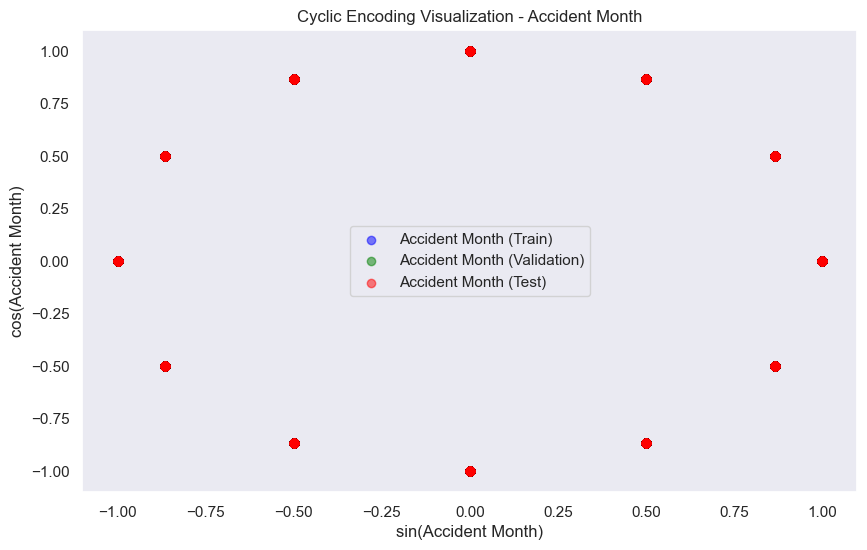

In [40]:
def cyclic_encode(data, columns, max_value):
    """
    Applies cyclic encoding to specified columns in the data.

    Parameters:
    - data: DataFrame containing the columns to encode.
    - columns: List of column names to encode.
    - max_value: Maximum value for the cyclic period (e.g., 12 for months).

    Returns:
    - Encoded DataFrame with '_sin' and '_cos' for each cyclic column.
    """
    for col in columns:
        # Apply the sine transformation for cyclic encoding
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col] / max_value)
         # Apply the cosine transformation for cyclic encoding
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col] / max_value)
        # Drop the original cyclic column as it's no longer needed
        data.drop(columns=[col], inplace=True)
    return data

# Cyclic features and maximum value for months
cyclic_features = ['Accident Month', 'Assembly Month', 'C-2 Date Month']
max_value = 12  # Max value for months in a year

# Apply cyclic encoding
X_train_cyclic_encoded = cyclic_encode(X_train_cyclic.copy(), cyclic_features, max_value)
X_val_cyclic_encoded = cyclic_encode(X_val_cyclic.copy(), cyclic_features, max_value)
X_test_cyclic_encoded = cyclic_encode(X_test_cyclic.copy(), cyclic_features, max_value)

# Visualize encoded features for a specific cyclic column (e.g., 'Accident Month')
plt.figure(figsize=(10, 6))

# Plot the encoded 'Accident Month' features for the training dataset
plt.scatter(
    X_train_cyclic_encoded['Accident Month_sin'], 
    X_train_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Train)', alpha=0.5, color='blue'
)

# Plot the encoded 'Accident Month' features for the validation dataset
plt.scatter(
    X_val_cyclic_encoded['Accident Month_sin'], 
    X_val_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Validation)', alpha=0.5, color='green'
)

# Plot the encoded 'Accident Month' features for the test dataset
plt.scatter(
    X_test_cyclic_encoded['Accident Month_sin'], 
    X_test_cyclic_encoded['Accident Month_cos'], 
    label='Accident Month (Test)', alpha=0.5, color='red'
)

# Set plot title and labels
plt.title('Cyclic Encoding Visualization - Accident Month')
plt.xlabel('sin(Accident Month)')
plt.ylabel('cos(Accident Month)')
plt.legend()
plt.grid()
plt.show()

## 3.4 Data Scaling for Target

In [41]:
y_train_DS.value_counts()

Target
2. NON-COMP        226777
4. TEMPORARY       113466
3. MED ONLY         53318
5. PPD SCH LOSS     36356
1. CANCELLED         8224
6. PPD NSL           3240
8. DEATH              353
7. PTD                 70
Name: count, dtype: int64

In [42]:
# Initialize the encoder
le = LabelEncoder()

# Define a predefined order for the categorical target variable
desired_order = ["1. CANCELLED", "2. NON-COMP", "3. MED ONLY", 
                 "4. TEMPORARY", "5. PPD SCH LOSS", 
                 "6. PPD NSL", "7. PTD", "8. DEATH"]

# Fit the encoder on the predefined order and transform the target values
y_train_encoded = le.fit(desired_order).transform(y_train_DS)

# Create a DataFrame with the encoded target values
y_train_encoded_df = pd.DataFrame(y_train_encoded, columns=['Encoded Target'], index=y_train_DS.index)



In [43]:
y_train_encoded_df

,Encoded Target
Claim Identifier,
5840724,3
5828518,1
5623558,4
5630561,2
5708079,1
...,...
6117605,1
5524219,3
5553447,1


In [44]:
# Transform the validation set labels using the already fitted LabelEncoder
y_val_encoded = le.transform(y_val_DS)

# Create a DataFrame with the encoded target values for the validation set
y_val_encoded_df = pd.DataFrame(y_val_encoded, columns=['Encoded Target'], index=y_val_DS.index)

In [45]:
y_val_encoded_df

,Encoded Target
Claim Identifier,
6003273,3
5659715,2
6070148,1
6108041,1
5519272,3
...,...
6066268,1
5704163,1
5579511,1


In [46]:
# Combine all processed features for train, validation, and test datasets
X_train_DS = pd.concat([X_train_numeric, ohc_train_df ,X_train_high_card_object_encoded, X_train_cyclic_encoded, X_train_binary], axis=1)
X_val_DS = pd.concat([X_val_numeric, ohc_val_df,X_val_high_card_object_encoded, X_val_cyclic_encoded, X_val_binary], axis=1)
X_test_DS = pd.concat([X_test_numeric, ohc_test_df,X_test_high_card_object_encoded, X_test_cyclic_encoded, X_test_binary], axis=1)

# Check the shapes of the final datasets
print("Final dataset shapes:")
print(f"X_train_DS shape: {X_train_DS.shape}")
print(f"y_train shape: {y_train_encoded_df.shape}")
print(f"X_val_DS shape: {X_val_DS.shape}")
print(f"y_val shape: {y_val_encoded_df.shape}")
print(f"X_test_DS shape: {X_test_DS.shape}")

# Display the columns of each dataset
print("\nColumns in X_train_DS:")
print(X_train_DS.columns.tolist())

print("\nColumns in X_val_DS:")
print(X_val_DS.columns.tolist())

print("\nColumns in X_test_DS:")
print(X_test_DS.columns.tolist())

# Optionally display the first few rows of y_train and y_val for inspection
print("\nFirst few rows of y_train:")
print(y_train_encoded_df.head())

print("\nFirst few rows of y_val:")
print(y_val_encoded_df.head())


Final dataset shapes:
X_train_DS shape: (441804, 91)
y_train shape: (441804, 1)
X_val_DS shape: (110586, 91)
y_val shape: (110586, 1)
X_test_DS shape: (387975, 91)

Columns in X_train_DS:
['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Number of Dependents', 'Accident Year', 'C-2 Date Year', 'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events', 'Carrier Accident Density', 'Industry Claim Percentage', 'Region Risk Percentage', 'Geo-Industry Risk', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)', 'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS', 'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Medical Fee Region_2', 'Medical Fee Region_3', 'Medical Fee Region_4

## Scaling the entire Data

In [47]:
# Initialize the MinMaxScaler for scaling the features
minmax_scaler = MinMaxScaler()

# Apply MinMax scaling to the training set and create a new DataFrame with the scaled values
X_train_DS_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_train_DS), columns=X_train_DS.columns, index=X_train_DS.index)

# Apply MinMax scaling to the validation set (using the same scaling as the training set)
X_val_DS_scaled = pd.DataFrame(minmax_scaler.transform(X_val_DS), columns=X_val_DS.columns, index=X_val_DS.index)

# Apply MinMax scaling to the test set (using the same scaling as the training set)
X_test_DS_scaled = pd.DataFrame(minmax_scaler.transform(X_test_DS), columns=X_test_DS.columns, index=X_test_DS.index)

In [48]:
X_train_DS_scaled.head()

,Age at Injury,Average Weekly Wage,Birth Year,Number of Dependents,Accident Year,C-2 Date Year,Assembly Year,Dependency-to-Income Ratio,Time Between Events,Carrier Accident Density,...,COVID-19 Indicator,First Hearing Date,Gender,Frequent Injury Cause,Accident on Weekday,Both C2 and C3,C-3 Date,Only C2,Only C3,No C2 or C3
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5840724,0.523077,0.516650,0.492754,0.166667,0.916667,0.785714,0.5,0.003431,0.000000,1.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5828518,0.446154,0.435209,0.565217,0.500000,0.916667,0.785714,0.5,0.012198,0.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5623558,0.276923,0.681425,0.710145,0.666667,0.833333,0.714286,0.0,0.010429,0.000000,0.022834,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5630561,0.230769,0.256223,0.753623,0.333333,0.833333,0.785714,0.5,0.013708,0.083333,0.157068,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5708079,0.646154,0.471537,0.376812,0.500000,0.916667,0.785714,0.5,0.011268,0.000000,0.013070,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [49]:
X_train_DS_scaled.to_csv('datasets/scaled_data_train_delivery1.csv')
y_train_encoded_df.to_csv('datasets/scaled_target_train_delivery1.csv')
X_val_DS_scaled.to_csv('datasets/scaled_data_val_delivery1.csv')
y_val_encoded_df.to_csv('datasets/scaled_target_val_delivery1.csv')
X_test_DS_scaled.to_csv('datasets/scaled_data_test_delivery1.csv')